Copyright 2021 The TensorFlow Similarity Authors.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import os
import random
import time
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# INFO messages are not printed.
# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [3]:
import tensorflow as tf

import tensorflow_datasets as tfds

In [4]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
    !pip install tensorflow_similarity
    import tensorflow_similarity as tfsim

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [5]:
from tensorflow_similarity.architectures import EfficientNetSim
from tensorflow_similarity.augmenters import SimCLRAugmenter
from tensorflow_similarity.callbacks import (
    EvalCallback,  # evaluate matching performance
)
from tensorflow_similarity.losses import Barlow, SimCLRLoss, SimSiamLoss
from tensorflow_similarity.models import ContrastiveModel
from tensorflow_similarity.samplers import SingleShotMemorySampler
from tensorflow_similarity.schedules import WarmUpCosine
from tensorflow_similarity.training_metrics import encoder_std  # # siam siam metric
from tensorflow_similarity.visualization import visualize_views

In [6]:
tfsim.utils.tf_cap_memory()  # Avoid GPU memory blow up

# Dataset

In [7]:
data_path = Path("../../kaggle_ds/google_landmarks")

## Loading

In [8]:
((x_raw_train, y_raw_train), (x_test, y_test)), ds_info = tfds.load(
    "cifar10",
    split=["train", "test"],
    batch_size=-1,
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [9]:
print(f"Class Names: {ds_info.features['label'].names}")

Class Names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [10]:
# Compute the indicies for query, index, val, and train splits
query_idxs, index_idxs, val_idxs, train_idxs = [], [], [], []
for cid in range(ds_info.features["label"].num_classes):
    idxs = tf.random.shuffle(tf.where(y_raw_train == cid))
    idxs = tf.reshape(idxs, (-1,))
    query_idxs.append(idxs[0])  # Single query example
    index_idxs.extend(idxs[1:101])  # 100 index examples
    val_idxs.extend(idxs[101:351])  # 250 validation examples
    train_idxs.extend(idxs[351:])  # The remaining are used for training

random.shuffle(query_idxs)
random.shuffle(index_idxs)
random.shuffle(val_idxs)
random.shuffle(train_idxs)

In [11]:
def create_split(idxs: list) -> tuple:
    x, y = [], []
    for idx in idxs:
        x.append(x_raw_train[int(idx)])
        y.append(y_raw_train[int(idx)])
    return tf.convert_to_tensor(x), tf.convert_to_tensor(y)


x_query, y_query = create_split(query_idxs)
x_index, y_index = create_split(index_idxs)
x_val, y_val = create_split(val_idxs)
x_train, y_train = create_split(train_idxs)

In [12]:
print(
    tabulate(
        [
            ["train", x_train.shape, y_train.shape],
            ["val", x_val.shape, y_val.shape],
            ["test", x_test.shape, y_test.shape],
            ["query", x_query.shape, y_query.shape],
            ["index", x_index.shape, y_index.shape],
        ],
        headers=["Examples", "Labels"],
    )
)

       Examples            Labels
-----  ------------------  --------
train  (46490, 32, 32, 3)  (46490,)
val    (2500, 32, 32, 3)   (2500,)
test   (10000, 32, 32, 3)  (10000,)
query  (10, 32, 32, 3)     (10,)
index  (1000, 32, 32, 3)   (1000,)


In [13]:
CIFAR_IMG_SIZE = 32
BATCH_SIZE = 128
INIT_LR = 1e-3
PRE_TRAIN_EPOCHS = 200
STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
WARMUP_STEPS = int(PRE_TRAIN_EPOCHS * STEPS_PER_EPOCH * 0.1)
WEIGHT_DECAY = 5e-4
DIM = 256

# Single Shot Sampler

In [14]:
train_augmenter = SimCLRAugmenter(CIFAR_IMG_SIZE, CIFAR_IMG_SIZE, is_training=True)


@tf.function()
def process(img, cid, num_augmentations_per_example, is_warmup):
    # SimClrAugmenter returns scaled values between [0,1]
    [view1, view2] = train_augmenter(img, cid, num_augmentations_per_example, is_warmup)
    # Effnet expects the inputs between [0, 255]
    return (view1 * 255.0, view2 * 255.0)


train_sampler = SingleShotMemorySampler(
    x_train,
    examples_per_batch=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    augmenter=process,
    num_augmentations_per_example=2,
)
val_sampler = SingleShotMemorySampler(
    x_val,
    examples_per_batch=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    augmenter=process,
    num_augmentations_per_example=2,
)


The initial batch size is 128 (128 classes * 1 examples per class) with 2 augmenters

The initial batch size is 128 (128 classes * 1 examples per class) with 2 augmenters


# Visualize Batching

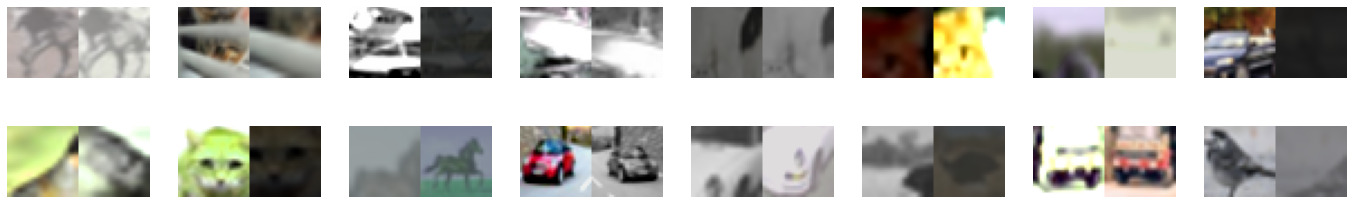

In [15]:
visualize_views(
    views=train_sampler.generate_batch(0), num_imgs=16, views_per_col=8, max_pixel_value=255.0
)

# Models

There are various architectures for building self-supervised models which may include some of the following:
* **Backbone**: This is the base model and is typically an existing architecture like ResNet or EfficientNet.
* **Projector**: This is a small multi-layer Neural Net and provides the embedding features at the end of training.
* **Predictor**: This model is used by BYOL and SimSiam and provides an additional small multi-layer Neural Net.

Typically, the projector and predictor networks are only 2 or 3 layers with batch normalization. Several papers claim that the batch normalization is critical to prevent the model from colapsing to a degenerate solution.

## Backbone Model

In [16]:
def get_backbone(img_size, dim, activation="relu", trainable=True):
    input_shape = (img_size, img_size, 3)
    backbone = EfficientNetSim(
        input_shape,
        embedding_size=dim,
        variant="B0",
        weights="imagenet",
        augmentation=tf.keras.layers.Resizing(224, 224),
        trainable="partial",
        gem_p=3.0,
        l2_norm=False,
    )
    return backbone


backbone = get_backbone(CIFAR_IMG_SIZE, DIM)
backbone.summary()

Model: "similarity_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
generalized_mean_pooling2d ( (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
Total params: 4,377,507
Trainable params: 3,993,000
Non-trainable params: 384,507
_________________________________________________________________


## Projector Model

In [17]:
def get_projector(input_dim, dim, activation="relu"):
    inputs = tf.keras.layers.Input((input_dim,))
    x = inputs

    for i in range(2):
        x = tf.keras.layers.Dense(
            dim,
            use_bias=False,
            name=f"projection_layer_{i}",
            kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY),
        )(x)
        x = tf.keras.layers.BatchNormalization(name=f"batch_normalization_{i}")(x)
        x = tf.keras.layers.Activation(activation, name=f"{activation}_activation_{i}")(
            x
        )
    o = tf.keras.layers.Dense(
        dim,
        use_bias=False,
        name="projection_output",
        kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY),
    )(x)
    projector = tf.keras.Model(inputs, o, name="projector")
    return projector


projector = get_projector(input_dim=256, dim=DIM)
projector.summary()

Model: "projector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
projection_layer_0 (Dense)   (None, 256)               65536     
_________________________________________________________________
batch_normalization_0 (Batch (None, 256)               1024      
_________________________________________________________________
relu_activation_0 (Activatio (None, 256)               0         
_________________________________________________________________
projection_layer_1 (Dense)   (None, 256)               65536     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
relu_activation_1 (Activatio (None, 256)               0 

## Predictor model

In [18]:
def get_predictor(input_dim, hiddin_dim=512, activation="relu"):
    inputs = tf.keras.layers.Input(shape=(input_dim,))
    x = inputs

    x = tf.keras.layers.Dense(
        hiddin_dim,
        activation=activation,
        use_bias=False,
        name="predictor_layer_0",
        kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY),
    )(x)
    x = tf.keras.layers.BatchNormalization(name="batch_normalization_0")(x)
    x = tf.keras.layers.Activation(activation, name=f"{activation}_activation_0")(x)

    o = tf.keras.layers.Dense(input_dim, name="predictor_output")(x)
    projector = tf.keras.Model(inputs, o, name="predictor")
    return projector


predictor = get_predictor(DIM, hiddin_dim=128)
predictor.summary()

Model: "predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
predictor_layer_0 (Dense)    (None, 128)               32768     
_________________________________________________________________
batch_normalization_0 (Batch (None, 128)               512       
_________________________________________________________________
relu_activation_0 (Activatio (None, 128)               0         
_________________________________________________________________
predictor_output (Dense)     (None, 256)               33024     
Total params: 66,304
Trainable params: 66,048
Non-trainable params: 256
_________________________________________________________________


# Self-Supervised Algorithms

In [19]:
ALGORITHM = "barlow"

In [20]:
if ALGORITHM == "barlow":
    loss = Barlow(name="barlow")

    contrastive_model = ContrastiveModel(
        backbone=backbone,
        projector=projector,
        algorithm="barlow",
        projector_embedding_layer_name="projection_layer_1",
    )
elif ALGORITHM == "simsiam":
    loss = SimSiamLoss(projection_type="cosine_distance", name="simsiam")

    contrastive_model = ContrastiveModel(
        backbone=backbone,
        projector=projector,
        predictor=predictor,
        algorithm="simsiam",
        projector_embedding_layer_name="projection_layer_1",
    )
elif ALGORITHM == "simclr":
    loss = SimCLRLoss(name="simclr")

    contrastive_model = ContrastiveModel(
        backbone=backbone,
        projector=projector,
        algorithm="simclr",
        projector_embedding_layer_name="projection_layer_1",
    )
else:
    raise ValueError(f"{ALGORITHM} is not supported.")

# Compile

In [21]:
lr_decayed_fn = WarmUpCosine(
    initial_learning_rate=1e-3,
    decay_steps=PRE_TRAIN_EPOCHS * STEPS_PER_EPOCH,
    warmup_steps=WARMUP_STEPS,
    warmup_learning_rate=0.0,
)
sgd = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn, momentum=0.9)
contrastive_model.compile(optimizer=sgd, loss=loss)

## Callbacks

In [22]:
log_dir = data_path / "models_owen" / f"logs/{loss.name}_{time.time()}"
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=5, restore_best_weights=True
)
tbc = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    update_freq=100,
)
tsc = EvalCallback(
    x_query, y_query, x_index, y_index, metrics=["f1", "precision", "recall"], k=1, tb_logdir=log_dir
)
mcp_train = tf.keras.callbacks.ModelCheckpoint(
    filepath=data_path / "models_owen" / "checkpoints" / f"{loss.name}_{time.time()}",
    monitor="loss",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
)

TensorBoard logging enable in ../../kaggle_ds/google_landmarks/models_owen/logs/barlow_1639088532.6879365/index


## Train

In [ ]:
history = contrastive_model.fit(
    train_sampler,
    epochs=PRE_TRAIN_EPOCHS,
    validation_data=val_sampler,
    validation_steps=10,
    callbacks=[early_stopping, tbc, tsc, mcp_train],
)

Epoch 1/200
363/363 [==============================] - 201s 515ms/step - loss: 85.7025 - val_loss: 53.9927
f1: 0.5714 - precision: 0.4000 - recall: 1.0000
Warmup complete
Epoch 2/200
363/363 [==============================] - 181s 500ms/step - loss: 49.6172 - val_loss: 44.6265
f1: 0.7500 - precision: 0.6000 - recall: 1.0000
Epoch 3/200
 25/363 [=>............................] - ETA: 2:46 - loss: 45.4429

In [ ]:
plt.plot(history.history["loss"])
plt.grid()
plt.title(loss.name)
plt.show()

# Evaluation

In [ ]:
from tensorflow_similarity.samplers import select_examples

# allows to use a fraction of the dataset via select_sample
x_restricted, y_restricted = select_examples(
    x_train, y_train, num_examples_per_class=1000
)
y_restricted = tf.keras.utils.to_categorical(y_restricted, 10)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, 10)

TEST_EPOCHS = 20
TEST_STEPS_PER_EPOCH = len(x_restricted) // BATCH_SIZE

In [ ]:
def get_eval_model(
    img_size,
    backbone,
    projector,
    projector_embedding_layer_name,
    projector_trainable=True,
):
    backbone.trainable = False
    embedding = tf.keras.Model(
        projector.input, projector.get_layer(projector_embedding_layer_name).output
    )
    embedding.trainable = projector_trainable
    inputs = tf.keras.layers.Input((img_size, img_size, 3), name="eval_input")
    x = backbone(inputs)
    x = embedding(x)
    o = tf.keras.layers.Dense(10, activation="softmax")(x)
    model = tf.keras.Model(inputs, o, name="no_pretrain")
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])
    return model

## No Pretrain

In [ ]:
no_pt_eval_model = get_eval_model(
    CIFAR_IMG_SIZE,
    get_backbone(CIFAR_IMG_SIZE, DIM),
    get_projector(input_dim=256, dim=DIM),
    projector_embedding_layer_name="projection_layer_1",
)
no_pt_history = no_pt_eval_model.fit(
    x_restricted,
    y_restricted,
    batch_size=BATCH_SIZE,
    epochs=TEST_EPOCHS,
    validation_data=(x_test, y_test_one_hot),
)

## Pretrained

In [ ]:
pt_eval_model = get_eval_model(
    CIFAR_IMG_SIZE,
    contrastive_model.backbone,
    contrastive_model.projector,
    projector_embedding_layer_name="projection_layer_1",
    projector_trainable=False,
)
pt_eval_model.summary()

In [ ]:
pt_history = pt_eval_model.fit(
    x_restricted,
    y_restricted,
    batch_size=BATCH_SIZE,
    epochs=TEST_EPOCHS,
    validation_data=(x_test, y_test_one_hot),
)

## Comparison

In [ ]:
print("no pretrain", no_pt_eval_model.evaluate(x_test, y_test_one_hot))
print("pretrained", pt_eval_model.evaluate(x_test, y_test_one_hot))